# tira_asr_noise
Measure correlation between various nosie measures on Tira ASR dataset
Sample 5 rows from each 10 bins of each measure and set aside for hand eval,
then visualize correlation of hand eval with objective measures.

In [42]:
from datasets import load_from_disk
from scipy.stats import pearsonr, spearmanr
from scipy.stats.mstats import mquantiles
import pandas as pd
import numpy as np
import torchaudio
import torch
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
from tqdm import tqdm
from matplotlib.colors import LogNorm

In [2]:
if sys.platform == "darwin":
    pardir = "/Users/markjos/projects/malachor5/data/dataset_clips/tira-asr"
else:
    pardir = r'C:\projects\malachor5\data\dataset_clips\tira-asr'
ds_path = os.path.join(pardir, "unprocessed_audio_ds")
hand_eval_dir = os.path.join(pardir, "hand-eval")
transcription_path = os.path.join(pardir, "transcriptions.csv")
align_metadata_path = os.path.join(pardir, 'mfa_output', 'alignment_metadata.csv')
os.makedirs(hand_eval_dir, exist_ok=True)

# Load data

In [3]:
transcriptions = pd.read_csv(transcription_path, index_col='index')
transcriptions

,audio_basename,start,end,duration,text,eaf_basename
index,,,,,,
0,HH20210707.wav,1350,2110,760,ɛ̀vɛ̀,HH20210707.eaf
1,HH20210707.wav,7900,9640,1740,ɛ̀vɛ̀ jìcə̀lò,HH20210707.eaf
2,HH20210707.wav,14135,17165,3030,ɪ́ŋgɛ́lǎ ŋ̀gáíjà ɛ̀vɛ̀,HH20210707.eaf
3,HH20210707.wav,26445,27065,620,càt̪à,HH20210707.eaf
4,HH20210707.wav,31830,34130,2300,ɪ́ŋgɛ́là ŋgáíjà ɛ̀vɛ̀ càt̪à,HH20210707.eaf
...,...,...,...,...,...,...
70759,HH20240308.wav,1926200,1927170,970,lá vr̀ðɔ̀ðɔ́,HH20240308.eaf
70760,HH20240308.wav,1938970,1940030,1060,lá vr̀ðɔ̀ðɔ́,HH20240308.eaf
70761,HH20240308.wav,1942570,1943470,900,lá vr̀ðɔ̀ðɔ́,HH20240308.eaf


In [4]:
ds = load_from_disk(ds_path)
ds

Dataset({
    features: ['audio', 'clip_name', 'index', 'vad_chunks', 'speech_embed', 'text_embed', 'embed_cos_sim', 'wada_snr', 'nist_snr', 'duration', 'vad_duration', 'vad_pct'],
    num_rows: 23261
})

In [5]:
a=np.array([1,2,3])

get_rms = lambda a: np.sqrt(np.power(a,2).sum()/len(a))
get_rms(a)

np.float64(2.160246899469287)

In [6]:
rms = [get_rms(row['audio']['array']) for row in tqdm(ds)]

100%|██████████| 23261/23261 [01:07<00:00, 342.21it/s]


In [7]:
peak_amp = [np.abs(row['audio']['array']).max() for row in tqdm(ds)]

100%|██████████| 23261/23261 [00:34<00:00, 674.95it/s]


In [8]:
ds = ds.add_column('rms', rms)
ds = ds.add_column('peak_amp', peak_amp)

# Show correlation for objective measures

In [9]:
objective_measures = ['vad_duration', 'vad_pct', 'embed_cos_sim', 'wada_snr', 'nist_snr', 'duration', 'rms', 'peak_amp']
for i, measure_1 in enumerate(objective_measures[:-1]):
    for j, measure_2 in enumerate(objective_measures[i+1:]):
        corr = pearsonr(ds[measure_1], ds[measure_2])
        print(f"{measure_1}, {measure_2}, corr={corr.statistic:.2f}, p val={corr.pvalue:.2f}")

vad_duration, vad_pct, corr=-0.06, p val=0.00
vad_duration, embed_cos_sim, corr=-0.05, p val=0.00
vad_duration, wada_snr, corr=0.08, p val=0.00
vad_duration, nist_snr, corr=0.14, p val=0.00
vad_duration, duration, corr=0.93, p val=0.00
vad_duration, rms, corr=0.08, p val=0.00
vad_duration, peak_amp, corr=0.17, p val=0.00
vad_pct, embed_cos_sim, corr=0.18, p val=0.00
vad_pct, wada_snr, corr=-0.34, p val=0.00
vad_pct, nist_snr, corr=-0.29, p val=0.00
vad_pct, duration, corr=-0.29, p val=0.00
vad_pct, rms, corr=0.00, p val=0.88
vad_pct, peak_amp, corr=-0.03, p val=0.00
embed_cos_sim, wada_snr, corr=-0.03, p val=0.00
embed_cos_sim, nist_snr, corr=-0.01, p val=0.21
embed_cos_sim, duration, corr=-0.08, p val=0.00
embed_cos_sim, rms, corr=0.06, p val=0.00
embed_cos_sim, peak_amp, corr=0.06, p val=0.00
wada_snr, nist_snr, corr=0.73, p val=0.00
wada_snr, duration, corr=0.14, p val=0.00
wada_snr, rms, corr=-0.13, p val=0.00
wada_snr, peak_amp, corr=-0.08, p val=0.00
nist_snr, duration, corr=0.17

# Create hand eval set
Sample from bins of each objective measure (*commenting out to avoid overwriting data!*)

In [10]:
# rows_added = []
# bin_sample_n = 5
# for measure in objective_measures:
#     print(measure)
#     bins = mquantiles(ds[measure], prob=np.linspace(0,1,10))
#     binned_measure = np.digitize(ds[measure], bins)
#     for bin in range(1, bins.shape[0]+1):
#         # print(bin, binned_measure[binned_measure==bin].shape)
#         bin_idcs = np.argwhere(binned_measure==bin).squeeze()
#         for _ in range(bin_sample_n):
#             new_idx = np.random.choice(bin_idcs)
#             while new_idx in rows_added:
#                 new_idx = np.random.choice(bin_idcs)
#             rows_added.append(new_idx)
# rows_added[:5], len(rows_added)

In [11]:
# hand_eval_ds = ds.select(rows_added)
# hand_eval_ds

In [12]:
# wav_files = []
# def row_to_wav(row, outdir: str) -> None:
#     """
#     Reads samples from a Dataset Audio row (in the form of a dictionary)
#     and save as a wav in the specified `outdir`.
#     """
#     index = row['index']
#     path = os.path.join(outdir, f"{index}.wav")
#     wav_files.append(path)
#     wav_array = row['audio']['array']
#     sr = row['audio']['sampling_rate']
#     # cast to torch tensor and make 2D
#     wav_tensor = torch.Tensor(wav_array).unsqueeze(0)
#     torchaudio.save(path, wav_tensor, sr)

#     text = transcriptions.at[index, 'text']

#     return {"index":index, "filename": os.path.basename(path), "text": text}

# df = hand_eval_ds.map(lambda row: row_to_wav(row, hand_eval_dir), remove_columns=hand_eval_ds.column_names).to_pandas()
# df = df.set_index("index")
# df=df.sort_index()
# likert_cols = [
#     "Audio quality",
#     "Crosstalk",
#     "Only Tira spoken?",
#     "Disfluencies?",
#     "Tira transcription accuracy",
# ]
# for col in likert_cols:
#     df[col]=''
# df.to_excel(os.path.join(hand_eval_dir, 'eval.xlsx'))


# Load subjective evaluations
Visualize correlation with objective measures

In [13]:
df = pd.read_excel(os.path.join(hand_eval_dir, 'eval.xlsx'), index_col='index')
df

,filename,text,Audio quality,Crosstalk,Only Tira spoken?,Disfluencies?,Tira transcription accuracy,Comments
index,,,,,,,,
125,125.wav,kə̀ŋàcîŋì r̀ŋɔ̀,5,5,5,5,5,NaN
479,479.wav,ŋèðèní ŋà t̪òlé t̪ɛ̂ɛ́,4,5,5,5,5,NaN
737,737.wav,ìró jìcə̀lò,2,5,5,5,5,NaN
802,802.wav,ɛ́rlɛ́nd̪ít̪ɔ́ àòr,2,5,5,5,5,Cuts off a bit early
864,864.wav,kìjàt̪ɔ́ kúkʊ̀ŋʊ́ ŋɔ́mɔ̀,2,4,5,4,5,NaN
...,...,...,...,...,...,...,...,...
69796,69796.wav,làrt̪ɔ́ úrnɔ̀ ŋəvəlɛða t̪ɔ́wə̀nì,2,5,5,5,5,NaN
69882,69882.wav,làɾt̪ɔ́loŋo lɛŋivəlɛða,2,5,5,5,5,NaN
69914,69914.wav,lánɔ́nà lʊ̀cɔ̀ nd̪ɔ̀bà,3,5,5,5,5,NaN


In [14]:
likert_cols = [
    "Audio quality",
    "Crosstalk",
    "Only Tira spoken?",
    "Disfluencies?",
    "Tira transcription accuracy",
]
subjective_measures = [
    "audio_quality",
    "crosstalk",
    "only_tira",
    "disfluencies",
    "tira_transcript_acc",
]
col_mapper = {likert_col:measure for likert_col, measure in zip(likert_cols, subjective_measures)}
df = df.rename(mapper=col_mapper, axis=1)
df

,filename,text,audio_quality,crosstalk,only_tira,disfluencies,tira_transcript_acc,Comments
index,,,,,,,,
125,125.wav,kə̀ŋàcîŋì r̀ŋɔ̀,5,5,5,5,5,NaN
479,479.wav,ŋèðèní ŋà t̪òlé t̪ɛ̂ɛ́,4,5,5,5,5,NaN
737,737.wav,ìró jìcə̀lò,2,5,5,5,5,NaN
802,802.wav,ɛ́rlɛ́nd̪ít̪ɔ́ àòr,2,5,5,5,5,Cuts off a bit early
864,864.wav,kìjàt̪ɔ́ kúkʊ̀ŋʊ́ ŋɔ́mɔ̀,2,4,5,4,5,NaN
...,...,...,...,...,...,...,...,...
69796,69796.wav,làrt̪ɔ́ úrnɔ̀ ŋəvəlɛða t̪ɔ́wə̀nì,2,5,5,5,5,NaN
69882,69882.wav,làɾt̪ɔ́loŋo lɛŋivəlɛða,2,5,5,5,5,NaN
69914,69914.wav,lánɔ́nà lʊ̀cɔ̀ nd̪ɔ̀bà,3,5,5,5,5,NaN


In [15]:
hand_selected_rows = [
    {
        col: row[col] for col in objective_measures+['index', 'clip_name']
    } for row in tqdm(ds) if row['index'] in df.index
]
hand_df_objective = pd.DataFrame(hand_selected_rows)
hand_df_objective=hand_df_objective.set_index('index')

100%|██████████| 23261/23261 [00:34<00:00, 666.63it/s]


In [16]:
df_join=df.join(hand_df_objective, on='index')
df_join

,filename,text,audio_quality,crosstalk,only_tira,disfluencies,tira_transcript_acc,Comments,vad_duration,vad_pct,embed_cos_sim,wada_snr,nist_snr,duration,rms,peak_amp,clip_name
index,,,,,,,,,,,,,,,,,
125,125.wav,kə̀ŋàcîŋì r̀ŋɔ̀,5,5,5,5,5,NaN,1.755000,0.943548,0.733028,16.070586,26.75,1.860,0.030453,0.161591,C:\Users\marks\AppData\Local\Temp\tmphss8xm40\...
479,479.wav,ŋèðèní ŋà t̪òlé t̪ɛ̂ɛ́,4,5,5,5,5,NaN,1.687500,0.809741,0.741243,25.575698,30.50,2.084,0.350474,1.000000,C:\Users\marks\AppData\Local\Temp\tmphss8xm40\...
737,737.wav,ìró jìcə̀lò,2,5,5,5,5,NaN,1.485000,0.972495,0.726637,26.123643,29.25,1.527,0.112274,0.603516,C:\Users\marks\AppData\Local\Temp\tmphss8xm40\...
802,802.wav,ɛ́rlɛ́nd̪ít̪ɔ́ àòr,2,5,5,5,5,Cuts off a bit early,2.311875,0.996498,0.710336,100.000000,56.50,2.320,0.050269,0.335999,C:\Users\marks\AppData\Local\Temp\tmphss8xm40\...
864,864.wav,kìjàt̪ɔ́ kúkʊ̀ŋʊ́ ŋɔ́mɔ̀,2,4,5,4,5,NaN,3.020625,0.691219,0.721320,100.000000,59.75,4.370,0.074514,0.580688,C:\Users\marks\AppData\Local\Temp\tmphss8xm40\...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69796,69796.wav,làrt̪ɔ́ úrnɔ̀ ŋəvəlɛða t̪ɔ́wə̀nì,2,5,5,5,5,NaN,1.653750,0.992647,0.784711,24.684563,9.00,1.666,0.065805,0.450165,C:\Users\marks\AppData\Local\Temp\tmphss8xm40\...
69882,69882.wav,làɾt̪ɔ́loŋo lɛŋivəlɛða,2,5,5,5,5,NaN,1.586250,0.991406,0.716183,30.303945,5.00,1.600,0.044951,0.187714,C:\Users\marks\AppData\Local\Temp\tmphss8xm40\...
69914,69914.wav,lánɔ́nà lʊ̀cɔ̀ nd̪ɔ̀bà,3,5,5,5,5,NaN,1.096875,0.988176,0.660820,15.006271,4.00,1.110,0.056473,0.195160,C:\Users\marks\AppData\Local\Temp\tmphss8xm40\...


Load in MFA metadata

In [17]:
mfa_df = pd.read_csv(align_metadata_path, index_col='index')
align_measures = mfa_df.columns.tolist()
mfa_df.head()

,wordlen_max,wordlen_min,wordlen_med,wordlen_avg,wordlen_std,phonelen_max,phonelen_min,phonelen_med,phonelen_avg,phonelen_std
index,,,,,,,,,,
0,0.62,0.62,0.620,0.620,0.000000,0.55,0.03,0.040,0.206667,0.297377
1,0.76,0.69,0.725,0.725,0.049497,0.67,0.03,0.080,0.161111,0.200714
10,0.54,0.54,0.540,0.540,0.000000,0.29,0.05,0.200,0.180000,0.121244
100,1.05,0.47,0.760,0.760,0.410122,0.29,0.03,0.165,0.152000,0.083905
101,0.72,0.72,0.720,0.720,0.000000,0.28,0.17,0.270,0.240000,0.060828


In [18]:
df_join = df_join.join(mfa_df, on='index')
df_join

,filename,text,audio_quality,crosstalk,only_tira,disfluencies,tira_transcript_acc,Comments,vad_duration,vad_pct,...,wordlen_max,wordlen_min,wordlen_med,wordlen_avg,wordlen_std,phonelen_max,phonelen_min,phonelen_med,phonelen_avg,phonelen_std
index,,,,,,,,,,,,,,,,,,,,,
125,125.wav,kə̀ŋàcîŋì r̀ŋɔ̀,5,5,5,5,5,NaN,1.755000,0.943548,...,1.170,0.44,0.8050,0.805000,0.516188,0.30,0.01,0.12,0.146364,0.084056
479,479.wav,ŋèðèní ŋà t̪òlé t̪ɛ̂ɛ́,4,5,5,5,5,NaN,1.687500,0.809741,...,0.450,0.12,0.4050,0.345000,0.155885,0.24,0.01,0.09,0.092000,0.055188
737,737.wav,ìró jìcə̀lò,2,5,5,5,5,NaN,1.485000,0.972495,...,0.747,0.73,0.7385,0.738500,0.012021,0.41,0.03,0.09,0.164111,0.132409
802,802.wav,ɛ́rlɛ́nd̪ít̪ɔ́ àòr,2,5,5,5,5,Cuts off a bit early,2.311875,0.996498,...,0.960,0.44,0.7000,0.700000,0.367696,0.37,0.03,0.09,0.116667,0.097266
864,864.wav,kìjàt̪ɔ́ kúkʊ̀ŋʊ́ ŋɔ́mɔ̀,2,4,5,4,5,NaN,3.020625,0.691219,...,1.420,0.57,0.7400,0.910000,0.449778,1.28,0.02,0.10,0.170625,0.305493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69796,69796.wav,làrt̪ɔ́ úrnɔ̀ ŋəvəlɛða t̪ɔ́wə̀nì,2,5,5,5,5,NaN,1.653750,0.992647,...,0.480,0.22,0.4000,0.375000,0.112694,0.15,0.03,0.07,0.065217,0.031604
69882,69882.wav,làɾt̪ɔ́loŋo lɛŋivəlɛða,2,5,5,5,5,NaN,1.586250,0.991406,...,0.810,0.58,0.6950,0.695000,0.162635,0.15,0.03,0.07,0.073158,0.030010
69914,69914.wav,lánɔ́nà lʊ̀cɔ̀ nd̪ɔ̀bà,3,5,5,5,5,NaN,1.096875,0.988176,...,0.390,0.33,0.3500,0.356667,0.030551,0.16,0.02,0.06,0.071333,0.037391


<Axes: >

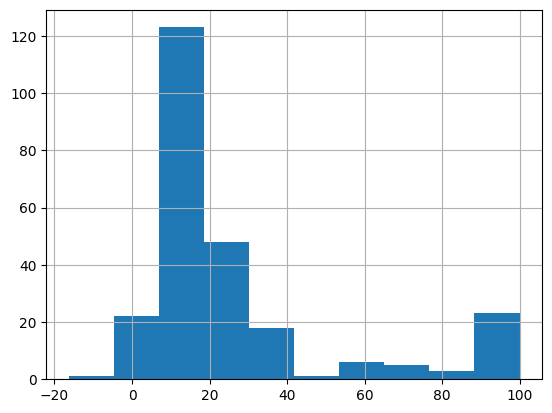

In [113]:
df_join['wada_snr'].hist()

In [115]:
no_100_snr_mask = (df_join['wada_snr'] < 100) & (df_join['nist_snr'] < 100)
no_100_snr_mask.value_counts()

True     228
False     22
Name: count, dtype: int64

In [ ]:
df_norm = pd.DataFrame(columns=objective_measures+subjective_measures+align_measures)
for measure in df_norm.columns:
    df_norm[measure]=(df_join.loc[no_100_snr_mask,measure]-df_join[measure].mean())/df_join[measure].std()
    # df_norm[measure]=(df_join[measure]-df_join[measure].mean())/df_join[measure].std()
df_norm

,vad_duration,vad_pct,embed_cos_sim,wada_snr,nist_snr,duration,rms,peak_amp,audio_quality,crosstalk,...,wordlen_max,wordlen_min,wordlen_med,wordlen_avg,wordlen_std,phonelen_max,phonelen_min,phonelen_med,phonelen_avg,phonelen_std
index,,,,,,,,,,,,,,,,,,,,,
125,-0.203084,-0.081718,0.668268,-0.396797,-0.043227,-0.192822,-0.660885,-0.769981,1.583615,0.142571,...,1.629370,0.044846,1.140064,1.086341,2.645190,0.152932,-1.178048,0.614462,1.054935,0.285069
479,-0.273697,-1.969106,0.800496,-0.049442,0.187360,-0.007756,5.397420,2.962358,0.788628,0.142571,...,-1.140071,-1.312596,-0.738208,-1.104643,-0.070054,-0.296340,-1.178048,-0.192625,-0.559107,-0.481685
737,-0.485537,0.326582,0.565408,-0.029418,0.110498,-0.467942,0.888061,1.197333,-0.801348,0.142571,...,0.002323,1.275028,0.827801,0.769601,-1.154211,0.976598,-0.047484,-0.192625,1.581853,1.569336
802,0.379476,0.665147,0.303057,2.670319,1.786100,0.187224,-0.285747,0.006429,-0.801348,0.142571,...,0.821616,0.044846,0.647018,0.586225,1.526152,0.677083,-0.047484,-0.192625,0.173240,0.635916
864,1.120915,-3.640892,0.479847,2.670319,1.985942,1.880905,0.173232,1.095713,-0.801348,-3.421707,...,2.590981,0.596307,0.834845,1.586457,2.144723,7.491044,-0.612766,0.076404,1.775249,6.166538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69796,-0.309004,0.610831,1.500079,-0.082008,-1.134675,-0.353102,0.008360,0.514662,-0.801348,0.142571,...,-1.024678,-0.888395,-0.761686,-0.961753,-0.395536,-0.970248,-0.047484,-0.730683,-1.354276,-1.108085
69882,-0.379617,0.593329,0.397162,0.123347,-1.380635,-0.407630,-0.386412,-0.653689,-0.801348,0.142571,...,0.244649,0.638727,0.623539,0.562410,-0.019186,-0.970248,-0.047484,-0.730683,-1.118525,-1.150430
69914,-0.891563,0.547761,-0.493866,-0.435691,-1.442125,-0.812462,-0.168302,-0.620541,-0.006360,0.142571,...,-1.370858,-0.421774,-0.996470,-1.049075,-1.014571,-0.895369,-0.612766,-0.999712,-1.172696,-0.954377


In [110]:
# corr_rows =  align_measures
corr_rows = ['vad_duration', 'vad_pct', 'embed_cos_sim', 'wada_snr', 'nist_snr', 'duration']
corr_cols = subjective_measures# + ['duration', 'rms', 'peak_amp']
corrmap=np.zeros((len(corr_rows), len(corr_cols)))
pvals=np.zeros_like(corrmap)
for i, obj_m in enumerate(corr_rows):
    for j, sbj_m in enumerate(corr_cols):
        corr = spearmanr(df_norm[obj_m], df_norm[sbj_m])
        # print(f"{obj_m}, {sbj_m}, corr={corr.statistic:.2f}, p val={corr.pvalue:.2f}")
        corrmap[i,j]=corr.statistic
        pvals[i,j]=corr.pvalue

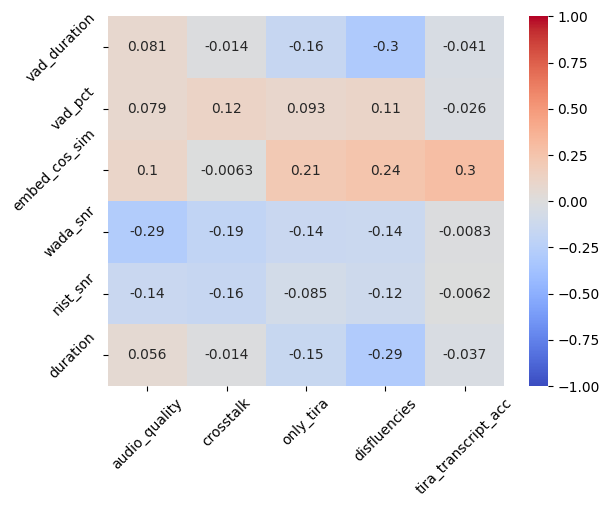

In [111]:
g=sns.heatmap(corrmap, cmap="coolwarm", vmin=-1, vmax=1, annot=True)
g.set_yticklabels(corr_rows, rotation=45)
g.set_xticklabels(corr_cols, rotation=45)
plt.show()

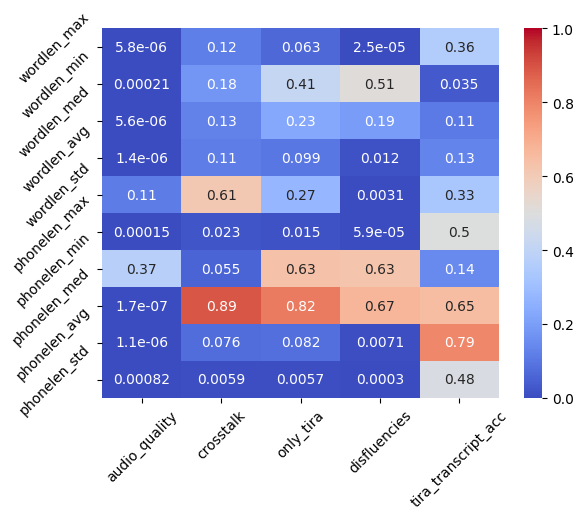

In [109]:
g=sns.heatmap(pvals, cmap="coolwarm", vmin=0, vmax=1, annot=True)
g.set_xticklabels(corr_cols, rotation=45)
g.set_yticklabels(corr_rows, rotation=45)
plt.show()

In [50]:
df_regress = df_norm.copy()
for col in df_regress.columns:
    if np.issubdtype(df_regress[col].dtype, np.floating):
        pos_z_score = df_regress[col]+1-df_regress[col].min()
        df_regress['log_'+col]=pos_z_score.apply(np.log)

df_regress['audio_basename']=transcriptions.loc[df_regress.index, 'audio_basename']
len(df_regress['audio_basename'].unique()), len(transcriptions['audio_basename'].unique())

(117, 184)

In [91]:
basename_counts = df_regress['audio_basename'].value_counts()
basenames_n_records = basename_counts[basename_counts>=5].index
basename_mask = df_regress['audio_basename'].isin(basenames_n_records)
len(df_regress[basename_mask]), len(df_regress.loc[basename_mask, 'audio_basename'].unique())

(38, 6)

In [102]:
align_measures

['wordlen_max',
 'wordlen_min',
 'wordlen_med',
 'wordlen_avg',
 'wordlen_std',
 'phonelen_max',
 'phonelen_min',
 'phonelen_med',
 'phonelen_avg',
 'phonelen_std']

In [106]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

sub_measure = "tira_transcript_acc"
# model = sm.OLS(df_norm['Audio quality'], df_norm[objective_measures])
# model = sm.OLS(df_norm['Audio quality'], df_norm[['wada_snr', 'nist_snr', 'duration']])
# model = sm.OLS(df_norm['Audio quality'], df_norm[['wada_snr', 'duration']])
# model = sm.OLS(df_norm['Audio quality'], df_norm[['nist_snr', 'duration']])
model = smf.ols(
# model = smf.mixedlm(
    formula=f"{sub_measure} ~ {'+'.join(['wordlen_max'])}",
    # formula=f"{sub_measure} ~ {'+'.join(corr_rows)} + C(audio_basename)",
    # formula=f"{sub_measure} ~ C(audio_basename)",
    # data=df_regress[basename_mask],
    data=df_regress,
    # groups=df_regress['audio_basename'],
)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     tira_transcript_acc   R-squared:                       0.027
Model:                             OLS   Adj. R-squared:                  0.023
Method:                  Least Squares   F-statistic:                     6.799
Date:                 Thu, 29 May 2025   Prob (F-statistic):            0.00967
Time:                         11:40:21   Log-Likelihood:                -350.85
No. Observations:                  250   AIC:                             705.7
Df Residuals:                      248   BIC:                             712.7
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    2.689e-17      0.063    4.3e-16      1.000      -0.123       0.123
wordlen_max    -0.1634      0.063     -2.607      0.010      -0.287      -0.040
==============================================================================
Omnibus:                      348.604   Durbin-Watson:                   1.692
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25713.919
Skew:                          -6.632   Prob(JB):                         0.00
Kurtosis:                      50.881   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""